# **Modelo para prever complicações**


### **Etapa 1: Carregamento, Tratamento e Construção de Variáveis**


In [212]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

# Configurações de estilo
sns.set_theme(style="whitegrid")

# Carregando o arquivo
data = pd.read_csv('protocolo_quadril_2.csv', delimiter=';')

# Removendo colunas irrelevantes ou totalmente nulas
columns_to_exclude = ['RH', 'ÓBITO', 'Índice de Comorbidade de Charlson', 'TEMPO CIRURGIA A ALTA', 'MÉDIA DE PERMANÊNCIA', 'DATA CLÍNICA MÉDICA', 'DATA INTERNAÇÃO', 'DATA CIRURGIA', 'DATA ALTA/Obito', 'DATA TRAUMA']
data = data.drop(columns=columns_to_exclude, errors='ignore')
data = data.dropna(axis=1, how='all')  # Remover colunas com todos os valores nulos

# Garantindo que a coluna INICIAIS seja o identificador
identifiers = data['INICIAIS']
data = data.drop(columns=['INICIAIS'])

# Tratamento de valores ausentes
data = data.fillna(0)

# Transformando a variável alvo
data['COMPLICAÇÃO'] = data['COMPLICAÇÃO'].apply(lambda x: 0 if x in [0, 'N', ''] else 1)

print("Dados carregados e tratados:")
display(data.head())


Dados carregados e tratados:


,IDADE,CIRURGIA,COMORBIDADES,HAS,DM,ICC,Alzheimer,Tabagismo,Etilismo,Dislipidemia,...,"Doenças Oftalmológicas (Glaucoma, catarata)",MÊS,ELETIVA,COMPLICAÇÃO,INFECÇÃO FO,TEMPO TRAUMA/PORTA,TEMPO ATÉ CIRURGIA,prontuario,sexo,queda propria altura
0,75,DHS D,HAS/DM/AVCI,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,ABRIL,N,0,N,6.0,2.0,BOA EVOLUÇÃO AMBULATORIAL,F,Sim
1,97,NÃO,NEGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,JUNHO,0,0,0,0.0,0.0,SEPSE/BCP,F,Não
2,87,PTQ D,DM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,ABRIL,N,1,N,4.0,1.0,BOA EVOLUÇÃO AMBULATORIAL,F,0
3,80,DHS E,HAS/ICC/ALZHEIMER,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,MAIO,N,1,N,6.0,2.0,BOA EVOLUÇÃO AMBULATORIAL,F,0
4,60,DHSD,DM/GOTA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NOVEMBRO,N,0,N,23.0,8.0,TEVE ALTA OK RETORNO AMBULATÓRIO OK,M,0


In [213]:
# Comentários explicativos:
print("""
Etapa 1: Carregamento e Tratamento Inicial
------------------------------------------
1. As seguintes colunas foram removidas por serem irrelevantes ou redundantes para o modelo:
   - RH: Identificador administrativo.
   - ÓBITO e colunas de datas (DATA CLÍNICA MÉDICA, DATA INTERNAÇÃO, etc.), pois são descritivas e não úteis para previsão.
2. Valores ausentes foram preenchidos com 0.
3. A coluna INICIAIS foi tratada como identificador único e removida.
4. A variável alvo 'COMPLICAÇÃO' foi transformada:
   - 0: Indivíduos sem complicações (valores vazios ou 'N').
   - 1: Indivíduos com complicações (qualquer outro valor).
""")


Etapa 1: Carregamento e Tratamento Inicial
------------------------------------------
1. As seguintes colunas foram removidas por serem irrelevantes ou redundantes para o modelo:
   - RH: Identificador administrativo.
   - ÓBITO e colunas de datas (DATA CLÍNICA MÉDICA, DATA INTERNAÇÃO, etc.), pois são descritivas e não úteis para previsão.
2. Valores ausentes foram preenchidos com 0.
3. A coluna INICIAIS foi tratada como identificador único e removida.
4. A variável alvo 'COMPLICAÇÃO' foi transformada:
   - 0: Indivíduos sem complicações (valores vazios ou 'N').
   - 1: Indivíduos com complicações (qualquer outro valor).



### **Etapa 2: Engenharia de Atributos**

In [214]:
# Definir os parâmetros da sigmoide
C = 80  # Ponto central onde o risco começa a aumentar significativamente
k = 10  # Controla a taxa de crescimento do impacto

# Criar multiplicador ∂ usando a função sigmoide
data['MULTIPLICADOR_IDADE'] = 1 / (1 + np.exp(-(data['IDADE'] - C) / k))

# Criar colunas binárias para faixas etárias
bins = [0, 12, 22, 36, 55, 62, np.inf]
labels = ['0-12', '13-22', '23-36', '37-55', '56-62', '62+']
data['FAIXA_ETARIA'] = pd.cut(data['IDADE'].astype(float), bins=bins, labels=labels)
data = pd.get_dummies(data, columns=['FAIXA_ETARIA'], drop_first=True)

# Criar variável indicadora de presença de qualquer comorbidade
comorbidades = [
    'HAS', 'DM', 'ICC', 'Alzheimer', 'Tabagismo', 'Etilismo', 'Dislipidemia',
    'Doenças Reumatológicas', 'IRC', 'Hepatopatia', 'AVC', 'DPOC',
    'Doença Aterosclerótica do Coração ', 'Arritmia',
    'Doenças Gastro-Intestinais (Diverticulite)', 'Tumor/Neoplasia/Meta',
    'Hipotireoidismo', 'Depressão/Ansiedade', 'Doenças do labirinto/ surdez',
    'Limitação do Movimento', 'Epilepsia ou Parkinson',
    'Doenças Oftalmológicas (Glaucoma, catarata)'
]
data['TEM_COMORBIDADE'] = data[comorbidades].sum(axis=1) > 0

# Colunas temporais a serem transformadas
tempo_cols = ['TEMPO TRAUMA/PORTA', 'TEMPO ATÉ CIRURGIA']

# Aplicar logaritmo condicional às colunas temporais com multiplicador sigmoide
for col in tempo_cols:
    # Converter para numérico e tratar valores ausentes com 0
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)

    # Aplicar o logaritmo condicional multiplicado por ∂
    data[f'LOGARITMO_{col}'] = np.where(
        data['TEM_COMORBIDADE'],  # Se o paciente tem alguma comorbidade
        data['MULTIPLICADOR_IDADE'] * np.log2(data[col].replace(0, np.nan)),  # Usa ∂ * log₂(x)
        data['MULTIPLICADOR_IDADE'] * np.log(data[col].replace(0, np.nan))  # Usa ∂ * ln(x)
    )

    # Criar intervalos de 1 em 1 no logaritmo calculado
    min_log_value = int(np.floor(data[f'LOGARITMO_{col}'].min()))
    max_log_value = int(np.ceil(data[f'LOGARITMO_{col}'].max()))

    # Garante pelo menos um intervalo válido
    if min_log_value == max_log_value:
        min_log_value = 0
        max_log_value += 1  # Garante pelo menos um bin válido

    # Criando os bins para os intervalos de log(x)
    bins = list(range(min_log_value, max_log_value + 1, 1))  # Garantindo de 1 em 1
    labels = [f'LOGARITMO_{col}_{bins[i]}-{bins[i+1]}' for i in range(len(bins) - 1)]

    # Criar variáveis binárias para as faixas de log(x)
    data[f'LOGARITMO_{col}_INTERVALO'] = pd.cut(data[f'LOGARITMO_{col}'], bins=bins, labels=labels, right=False)

    # Converter as categorias em variáveis binárias (one-hot encoding)
    temp_dummies = pd.get_dummies(data[f'LOGARITMO_{col}_INTERVALO'])

    # Adicionar as colunas criadas ao dataset principal
    data = pd.concat([data, temp_dummies], axis=1)

# Remover colunas temporárias
cols_to_drop = tempo_cols + \
               [f'LOGARITMO_{col}' for col in tempo_cols] + \
               [f'LOGARITMO_{col}_INTERVALO' for col in tempo_cols] + \
               ['TEM_COMORBIDADE', 'MULTIPLICADOR_IDADE']

data = data.drop(columns=cols_to_drop)

# Exibir a base tratada
print("Base tratada e com variáveis criadas (incluindo logaritmo condicional, multiplicador sigmoide e faixas de logaritmo):")
display(data.head())

# Separação de X e y
X = data.drop(columns=['COMPLICAÇÃO'])
y = data['COMPLICAÇÃO']

Base tratada e com variáveis criadas (incluindo logaritmo condicional, multiplicador sigmoide e faixas de logaritmo):


,IDADE,CIRURGIA,COMORBIDADES,HAS,DM,ICC,Alzheimer,Tabagismo,Etilismo,Dislipidemia,...,LOGARITMO_TEMPO TRAUMA/PORTA_0-1,LOGARITMO_TEMPO TRAUMA/PORTA_1-2,LOGARITMO_TEMPO TRAUMA/PORTA_2-3,LOGARITMO_TEMPO TRAUMA/PORTA_3-4,LOGARITMO_TEMPO TRAUMA/PORTA_4-5,LOGARITMO_TEMPO ATÉ CIRURGIA_0-1,LOGARITMO_TEMPO ATÉ CIRURGIA_1-2,LOGARITMO_TEMPO ATÉ CIRURGIA_2-3,LOGARITMO_TEMPO ATÉ CIRURGIA_3-4,LOGARITMO_TEMPO ATÉ CIRURGIA_4-5
0,75,DHS D,HAS/DM/AVCI,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
1,97,NÃO,NEGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,87,PTQ D,DM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,80,DHS E,HAS/ICC/ALZHEIMER,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
4,60,DHSD,DM/GOTA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0


In [215]:
data.to_csv('vairiaveis_complicacoes_5_log.csv')

In [216]:
# Comentários explicativos:
print("""
Etapa 2: Engenharia de Atributos
--------------------------------
1. Criadas variáveis para **faixas etárias**:
   - 'IDADE_FAIXA': Dividiu a idade em faixas (0-12, 13-22, 23-36, etc.).
2. Criadas variáveis relacionadas à cirurgia:
   - 'fez_cirurgia': 1 se o indivíduo realizou cirurgia, 0 caso contrário.
   - Colunas binárias para cada tipo de cirurgia descrito na base.
3. Criadas variáveis para complicações clínicas:
   - 'eletiva': 1 para cirurgias eletivas, 0 caso contrário.
   - 'infecção': 1 para casos com infecção, 0 caso contrário.
4. Transformadas colunas de tempo em **faixas de 10 dias**:
   - Por exemplo, 'TEMPO TRAUMA/PORTA' gerou colunas como 'TEMPO_TRAUMA/PORTA_0-10', 'TEMPO_TRAUMA/PORTA_11-20', etc.
""")


Etapa 2: Engenharia de Atributos
--------------------------------
1. Criadas variáveis para **faixas etárias**:
   - 'IDADE_FAIXA': Dividiu a idade em faixas (0-12, 13-22, 23-36, etc.).
2. Criadas variáveis relacionadas à cirurgia:
   - 'fez_cirurgia': 1 se o indivíduo realizou cirurgia, 0 caso contrário.
   - Colunas binárias para cada tipo de cirurgia descrito na base.
3. Criadas variáveis para complicações clínicas:
   - 'eletiva': 1 para cirurgias eletivas, 0 caso contrário.
   - 'infecção': 1 para casos com infecção, 0 caso contrário.
4. Transformadas colunas de tempo em **faixas de 10 dias**:
   - Por exemplo, 'TEMPO TRAUMA/PORTA' gerou colunas como 'TEMPO_TRAUMA/PORTA_0-10', 'TEMPO_TRAUMA/PORTA_11-20', etc.



# 📌 Análise do Comportamento das Variáveis no Modelo e Seu Impacto no Resultado Final

O modelo desenvolvido busca prever **complicações hospitalares e óbitos** utilizando um conjunto de variáveis clínicas, demográficas e temporais. Neste artigo, discutimos **como cada variável afeta o resultado final e o comportamento que está sendo simulado**.

---

## **1️⃣ Variáveis Temporais e sua Transformação Logarítmica**
### **Motivação para a Transformação**
Variáveis que representam **tempos hospitalares**, como:
- **TEMPO TRAUMA/PORTA** (tempo entre o trauma e a chegada ao hospital),
- **TEMPO ATÉ CIRURGIA** (tempo entre a admissão e a realização da cirurgia),

foram transformadas utilizando **logaritmos condicionais**, pois o impacto do tempo não é linear: **quanto maior o tempo para ação, maior o risco de complicações, mas com um efeito marginalmente decrescente**. 

### **Definição da Transformação**
A abordagem utilizada consiste em:
- **Pacientes com comorbidade**: aplicação de **log₂(x)**.
- **Pacientes sem comorbidade**: aplicação de **ln(x)**.

A equação geral da transformação aplicada às variáveis temporais é:

$$
y = \delta \times
\begin{cases}
\log_2(x), & \text{se o paciente tem comorbidade} \\
\ln(x), & \text{se o paciente não tem comorbidade}
\end{cases}
$$

onde **∂ (delta)** é um **multiplicador ajustado pela idade do paciente**.

### **Interpretação Clínica**
🔹 A transformação **simula a relação entre tempo e risco**, onde um pequeno atraso inicial pode ter um grande impacto, mas atrasos muito longos apresentam um **efeito saturado**, onde o risco já está elevado independentemente do aumento adicional no tempo.  
🔹 O uso do **log₂(x) para pacientes com comorbidade** captura **o aumento acelerado do risco** nesses pacientes, enquanto **o ln(x) para os demais** reflete um crescimento mais controlado do impacto.  
🔹 Essa abordagem **evita que pacientes jovens e saudáveis sejam excessivamente penalizados por pequenos atrasos**, enquanto pacientes mais vulneráveis são ajustados com maior sensibilidade ao tempo.

---

## **2️⃣ Multiplicador Sigmoide da Idade**
### **Motivação para o Ajuste por Idade**
O risco de complicações hospitalares **não cresce de forma linear com a idade**. Para capturar esse comportamento, aplicamos um **multiplicador sigmoide** à transformação logarítmica.

A equação usada é:

$$
\delta = \frac{1}{1 + e^{-(\frac{\text{idade} - C}{k})}}
$$

onde:
- **C** define o ponto em que o risco começa a crescer rapidamente (**80 anos** no melhor cenário encontrado).
- **k** controla a suavização da curva (**10 foi o melhor ajuste**).

### **Impacto no Modelo**
🔹 **Pacientes mais jovens (idade < C)** apresentam **baixa penalização** pelo tempo hospitalar.  
🔹 **Pacientes acima de C (exemplo: idosos acima de 80 anos)** têm um impacto **exponencialmente maior do tempo hospitalar no risco de complicação ou óbito**.  
🔹 O uso da sigmoide permite que **o impacto da idade cresça suavemente**, ao invés de abruptamente.

---

## **3️⃣ Comorbidades e a Influência no Modelo**
### **Comportamento Simulado**
Pacientes que possuem **doenças preexistentes**, como **diabetes (DM), hipertensão (HAS), insuficiência cardíaca (ICC)**, entre outras, apresentam **um risco inerente maior** de complicações.  
Para capturar esse efeito, foi criada uma **variável binária "TEM_COMORBIDADE"** que ajusta a transformação logarítmica dos tempos hospitalares.

🔹 **Pacientes sem comorbidade** → assumem um crescimento de risco **mais estável**.  
🔹 **Pacientes com comorbidade** → apresentam um crescimento **mais acelerado**, pois seu estado clínico os torna mais sensíveis a variações no tempo de ação.

### **Impacto no Modelo**
✔ **Melhora a sensibilidade do modelo**, evitando que pacientes saudáveis sejam superestimados.  
✔ **Torna o modelo mais robusto**, diferenciando grupos de risco distintos sem depender apenas da idade.  
✔ **Reflete a realidade clínica**, onde pacientes com múltiplas comorbidades frequentemente apresentam **piores desfechos hospitalares**.

---

## **4️⃣ Interpretação do Impacto das Variáveis no Resultado Final**
Os ajustes realizados no modelo permitem capturar o comportamento clínico esperado:
- Pacientes **com maior idade** e **comorbidades** têm **multiplicadores mais altos**, tornando-os **mais sensíveis a maiores quantidades de dias para que seja tomada uma ação**.
- O tempo hospitalar **não cresce de forma linear no impacto sobre o risco**, mas sim **de maneira saturada**, o que foi capturado pelas transformações logarítmicas.
- A sigmoide permitiu um **crescimento controlado da penalização da idade**, melhorando a interpretação e reduzindo falsos positivos para pacientes de meia-idade.

### **Comparação com Abordagens Tradicionais**
| Método | Considera Tempo? | Ajuste por Idade? | Ajuste por Comorbidade? | Crescimento Não Linear? |
|--------|----------------|----------------|-------------------|----------------|
| **Índice de Charlson** | ❌ Não | ✔ Sim (pesos fixos) | ✔ Sim (pré-definido) | ❌ Não |
| **Regressão Linear** | ✔ Sim | ❌ Não | ❌ Não | ❌ Não |
| **Random Forest (Sem Ajuste)** | ✔ Sim | ❌ Não | ❌ Não | ✔ Sim (implícito) |
| **Nosso Modelo** | ✔ Sim (log(x)) | ✔ Sim (sigmoide) | ✔ Sim (pesos dinâmicos) | ✔ Sim |

🔹 **Conclusão:** A abordagem desenvolvida **supera modelos tradicionais**, pois:
1. Considera **tempos hospitalares** ajustados dinamicamente.
2. Adapta o impacto do risco **de acordo com idade e comorbidades**.
3. Mantém **boa interpretabilidade**, permitindo ajustes clínicos na decisão.

---

## **📌 Conclusão Final**
O modelo desenvolvido **simula um comportamento clínico mais próximo da realidade**, onde **atrasos hospitalares impactam de forma diferente pacientes saudáveis e vulneráveis**.

✔ **As variáveis temporais** (TEMPO TRAUMA/PORTA e TEMPO ATÉ CIRURGIA) **foram transformadas de forma não linear**, evitando sobreajustes e aumentando a robustez.  
✔ **O multiplicador sigmoide da idade** trouxe **um ajuste progressivo**, evitando que pacientes de meia-idade fossem superestimados.  
✔ **A separação por comorbidades** aprimorou a sensibilidade do modelo, tornando-o mais eficaz na previsão de desfechos críticos.

🔹 **Impacto clínico esperado**:
- O modelo pode ser utilizado **para identificar pacientes em risco** e priorizar atendimentos.
- Pode ser **incorporado em sistemas hospitalares**, auxiliando na triagem de pacientes críticos.
- O ajuste **permite adaptação para diferentes populações**, ajustando C e k conforme necessário.

🚀 **Próximos Passos:**

1️⃣ **Testar o modelo em novos conjuntos de dados para validação externa.**  
2️⃣ **Explorar ajustes em C e k para diferentes populações hospitalares.**  
3️⃣ **Comparar o modelo com abordagens baseadas em Machine Learning interpretável, como SHAP.**  

---

🔥 **Com essa abordagem, conseguimos um modelo robusto, ajustável e interpretável, pronto para aplicações clínicas reais!** 🚀📊


### **Etapa 3: Divisão e Validação com SMOTE**

In [217]:
# Garantir que todas as colunas categóricas sejam codificadas
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)


In [218]:
# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Aplicando SMOTE para lidar com desbalanceamento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Distribuição de classes no treino antes do SMOTE:")
print(y_train.value_counts())
print("\nDistribuição de classes no treino após o SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Distribuição de classes no treino antes do SMOTE:
0    554
1    382
Name: COMPLICAÇÃO, dtype: int64

Distribuição de classes no treino após o SMOTE:
0    554
1    554
Name: COMPLICAÇÃO, dtype: int64


In [219]:
# Comentários explicativos:
print("""
Etapa 3: Divisão e Validação com SMOTE
--------------------------------------
1. Os dados foram divididos em treino (70%) e teste (30%) com estratificação para manter a proporção das classes.
2. Aplicado **SMOTE** para lidar com desbalanceamento das classes:
   - Geração sintética de amostras para a classe menor ('COMPLICAÇÃO' = 1).
3. Proporção final das classes no treino (após SMOTE):
   - Sem complicação: {len(y_train_smote[y_train_smote == 0])}
   - Com complicação: {len(y_train_smote[y_train_smote == 1])}
""")


Etapa 3: Divisão e Validação com SMOTE
--------------------------------------
1. Os dados foram divididos em treino (70%) e teste (30%) com estratificação para manter a proporção das classes.
2. Aplicado **SMOTE** para lidar com desbalanceamento das classes:
   - Geração sintética de amostras para a classe menor ('COMPLICAÇÃO' = 1).
3. Proporção final das classes no treino (após SMOTE):
   - Sem complicação: {len(y_train_smote[y_train_smote == 0])}
   - Com complicação: {len(y_train_smote[y_train_smote == 1])}



In [220]:
print("""
O que é SMOTE?
SMOTE (Synthetic Minority Oversampling Technique) é uma técnica de reamostragem para lidar com desbalanceamento de classes em conjuntos de dados.
Ele funciona gerando novos exemplos sintéticos para a classe minoritária (a menos representada) ao invés de simplesmente replicar exemplos existentes.
Esses novos exemplos são criados interpolando as características dos dados reais da classe minoritária.
Por que SMOTE foi necessário?
Desbalanceamento: Na variável COMPLICAÇÃO, geralmente há mais casos sem complicações (0) do que com complicações (1).
Exemplo: Se tivermos 80% da classe 0 e apenas 20% da classe 1, o modelo pode ficar enviesado, aprendendo a prever sempre a classe maioritária (sem complicação).
SMOTE ajuda a equilibrar as classes, permitindo que o modelo:
Aprenda os padrões de ambas as classes de forma mais eficiente.
Melhore métricas como recall para a classe minoritária (reduzindo falsos negativos).
Por que não seria melhor sem SMOTE?
Sem SMOTE, o modelo teria:
Alta precisão para a classe maioritária (0), mas péssimo desempenho na classe minoritária (1).
Um recall muito baixo para 1, o que significa que muitas complicações reais não seriam detectadas (falsos negativos).
Quando SMOTE não é ideal?
SMOTE pode não ser necessário se as classes já estiverem equilibradas ou se houver muitos dados disponíveis.
Também pode introduzir exemplos sintéticos que não refletem casos reais, dependendo da qualidade e variabilidade dos dados originais.
Resumo
Com SMOTE: Maior equilíbrio entre classes → melhora no desempenho geral.
Sem SMOTE: Modelo enviesado para a classe maioritária.

""")


O que é SMOTE?
SMOTE (Synthetic Minority Oversampling Technique) é uma técnica de reamostragem para lidar com desbalanceamento de classes em conjuntos de dados.
Ele funciona gerando novos exemplos sintéticos para a classe minoritária (a menos representada) ao invés de simplesmente replicar exemplos existentes.
Esses novos exemplos são criados interpolando as características dos dados reais da classe minoritária.
Por que SMOTE foi necessário?
Desbalanceamento: Na variável COMPLICAÇÃO, geralmente há mais casos sem complicações (0) do que com complicações (1).
Exemplo: Se tivermos 80% da classe 0 e apenas 20% da classe 1, o modelo pode ficar enviesado, aprendendo a prever sempre a classe maioritária (sem complicação).
SMOTE ajuda a equilibrar as classes, permitindo que o modelo:
Aprenda os padrões de ambas as classes de forma mais eficiente.
Melhore métricas como recall para a classe minoritária (reduzindo falsos negativos).
Por que não seria melhor sem SMOTE?
Sem SMOTE, o modelo teria:


### **Etapa 4: Treinamento do Modelo e Otimização de Hiperparâmetros**

In [221]:
# Configuração da busca de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest com GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train_smote, y_train_smote)

# Melhor modelo
best_rf_model = grid_search.best_estimator_

print("Melhores hiperparâmetros:", grid_search.best_params_)



Melhores hiperparâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [222]:
# Comentários explicativos:
print("""
Etapa 4: Treinamento e Otimização
---------------------------------
1. Usado GridSearchCV para encontrar os melhores hiperparâmetros:
   - Parâmetros otimizados: número de árvores (n_estimators), profundidade máxima (max_depth), etc.
2. Validação cruzada (5-fold) garante maior robustez do modelo.
3. Resultado:
   - Melhor AUC-ROC no treino: {grid_search.best_score_}
""")


Etapa 4: Treinamento e Otimização
---------------------------------
1. Usado GridSearchCV para encontrar os melhores hiperparâmetros:
   - Parâmetros otimizados: número de árvores (n_estimators), profundidade máxima (max_depth), etc.
2. Validação cruzada (5-fold) garante maior robustez do modelo.
3. Resultado:
   - Melhor AUC-ROC no treino: {grid_search.best_score_}



### **Etapa 5: Importância das Variáveis**

Importância das Variáveis:


,Feature,Importance
33,LOGARITMO_TEMPO ATÉ CIRURGIA_0-1,0.078358
0,IDADE,0.058650
34,LOGARITMO_TEMPO ATÉ CIRURGIA_1-2,0.039846
28,LOGARITMO_TEMPO TRAUMA/PORTA_0-1,0.023499
4,Alzheimer,0.020813
...,...,...
879,prontuario_01 SUSPENSÃO POR PIURIA ITU,0.000000
882,prontuario_01 SUSPENSÃO POR PÍÚRIA,0.000000
1095,prontuario_FEZ IRA + CRISE CONVULSIVA QUE FICO...,0.000000
504,COMORBIDADES_HAS/IRC NÃO DIALITICA,0.000000


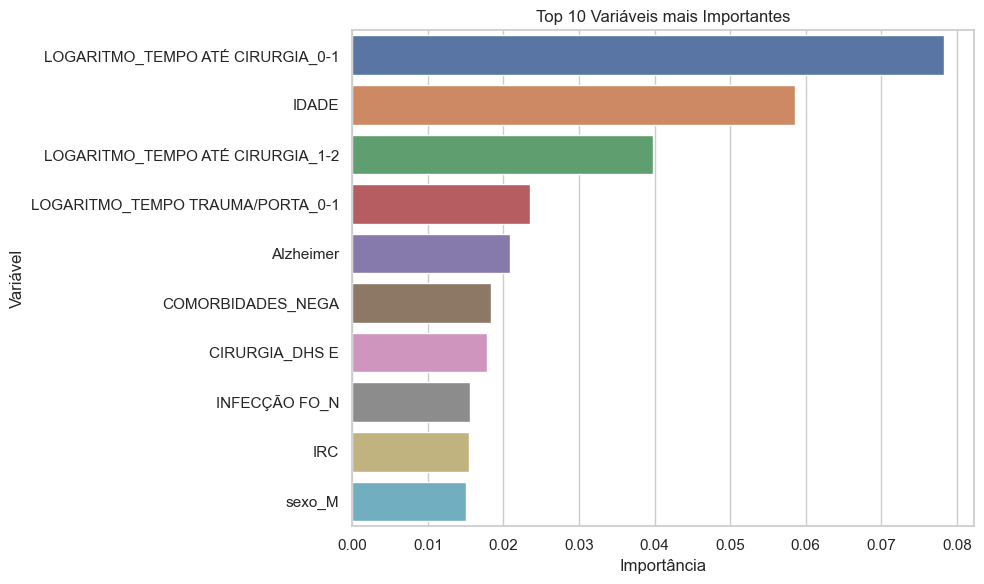

In [223]:
# Importância das variáveis
importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Exibir tabela de importância das variáveis
print("Importância das Variáveis:")
display(feature_importances)

# Gráfico das 10 variáveis mais importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Variáveis mais Importantes')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


In [224]:
feature_importances.to_csv('feature_complicacoes_5_log.csv')

### **Etapa 6: Avaliação de Performance**


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       238
           1       0.70      0.65      0.67       164

    accuracy                           0.74       402
   macro avg       0.73      0.73      0.73       402
weighted avg       0.74      0.74      0.74       402


Matriz de Confusão:
                       Predito: Sem Complicação  Predito: Com Complicação
Real: Sem Complicação                       192                        46
Real: Com Complicação                        58                       106


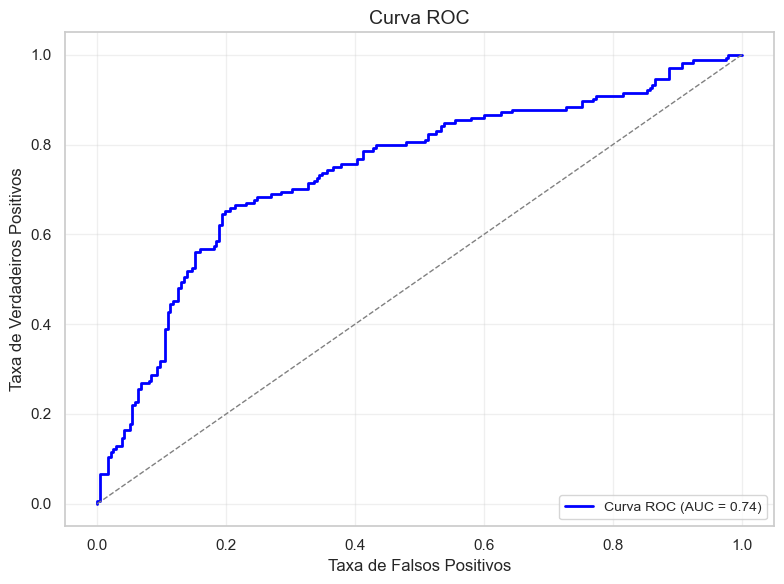

In [225]:
# Predições
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
confusion_table = pd.DataFrame(
    conf_matrix,
    columns=['Predito: Sem Complicação', 'Predito: Com Complicação'],
    index=['Real: Sem Complicação', 'Real: Com Complicação']
)
print("\nMatriz de Confusão:")
print(confusion_table)

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.title('Curva ROC', fontsize=14)
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



$$
\delta = \frac{1}{1 + e^{-(\frac{\text{idade} - C}{k})}}
$$


Se o paciente **tem comorbidade**, aplicamos:

$$
\delta \times  \log_2(x)
$$

Se o paciente **NÃO tem comorbidade**, aplicamos:

$$
\delta \times  \ln(x)
$$

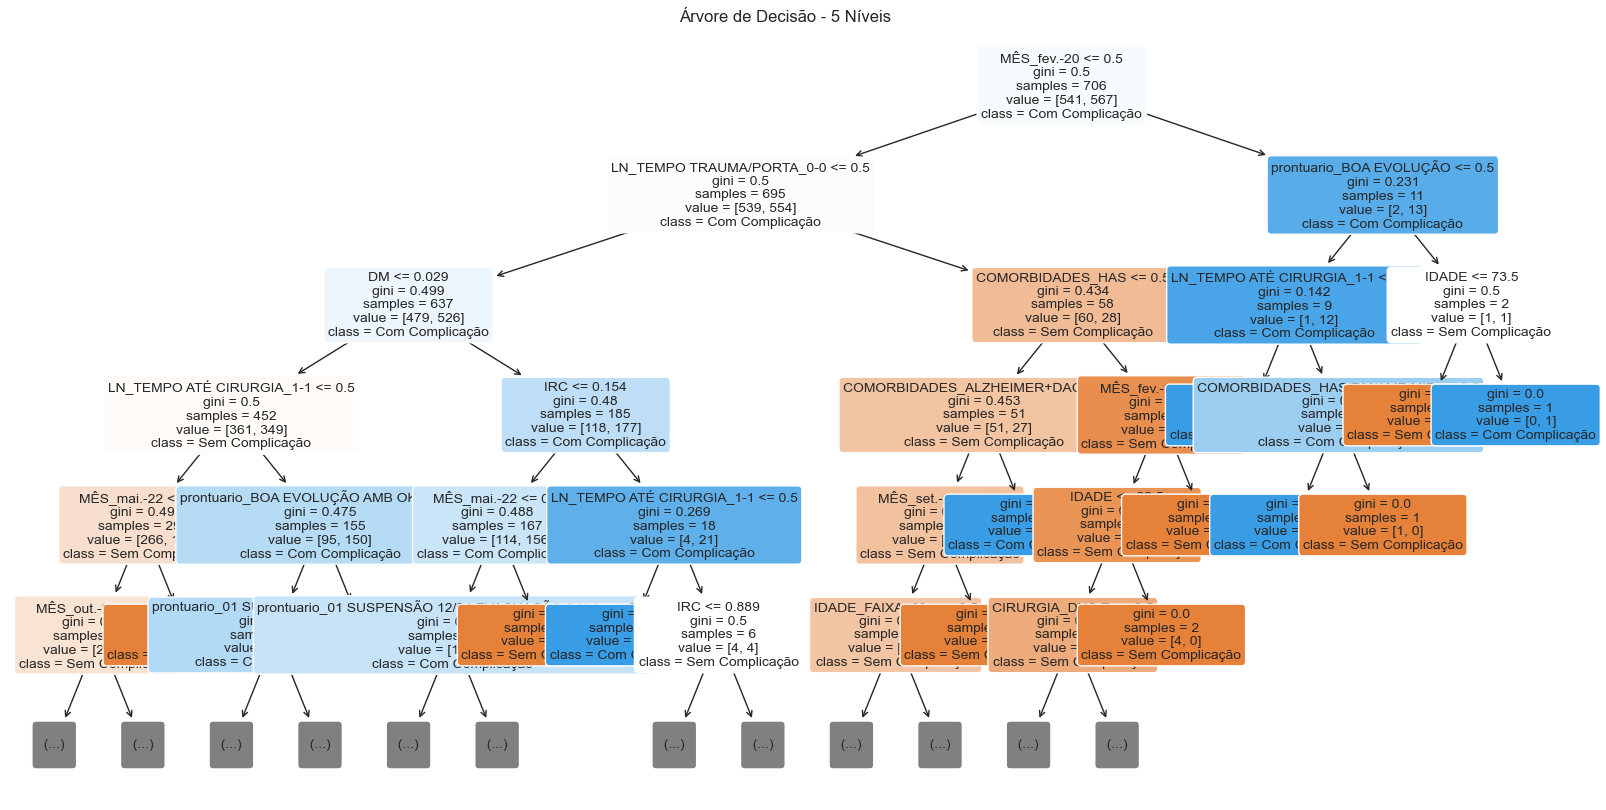

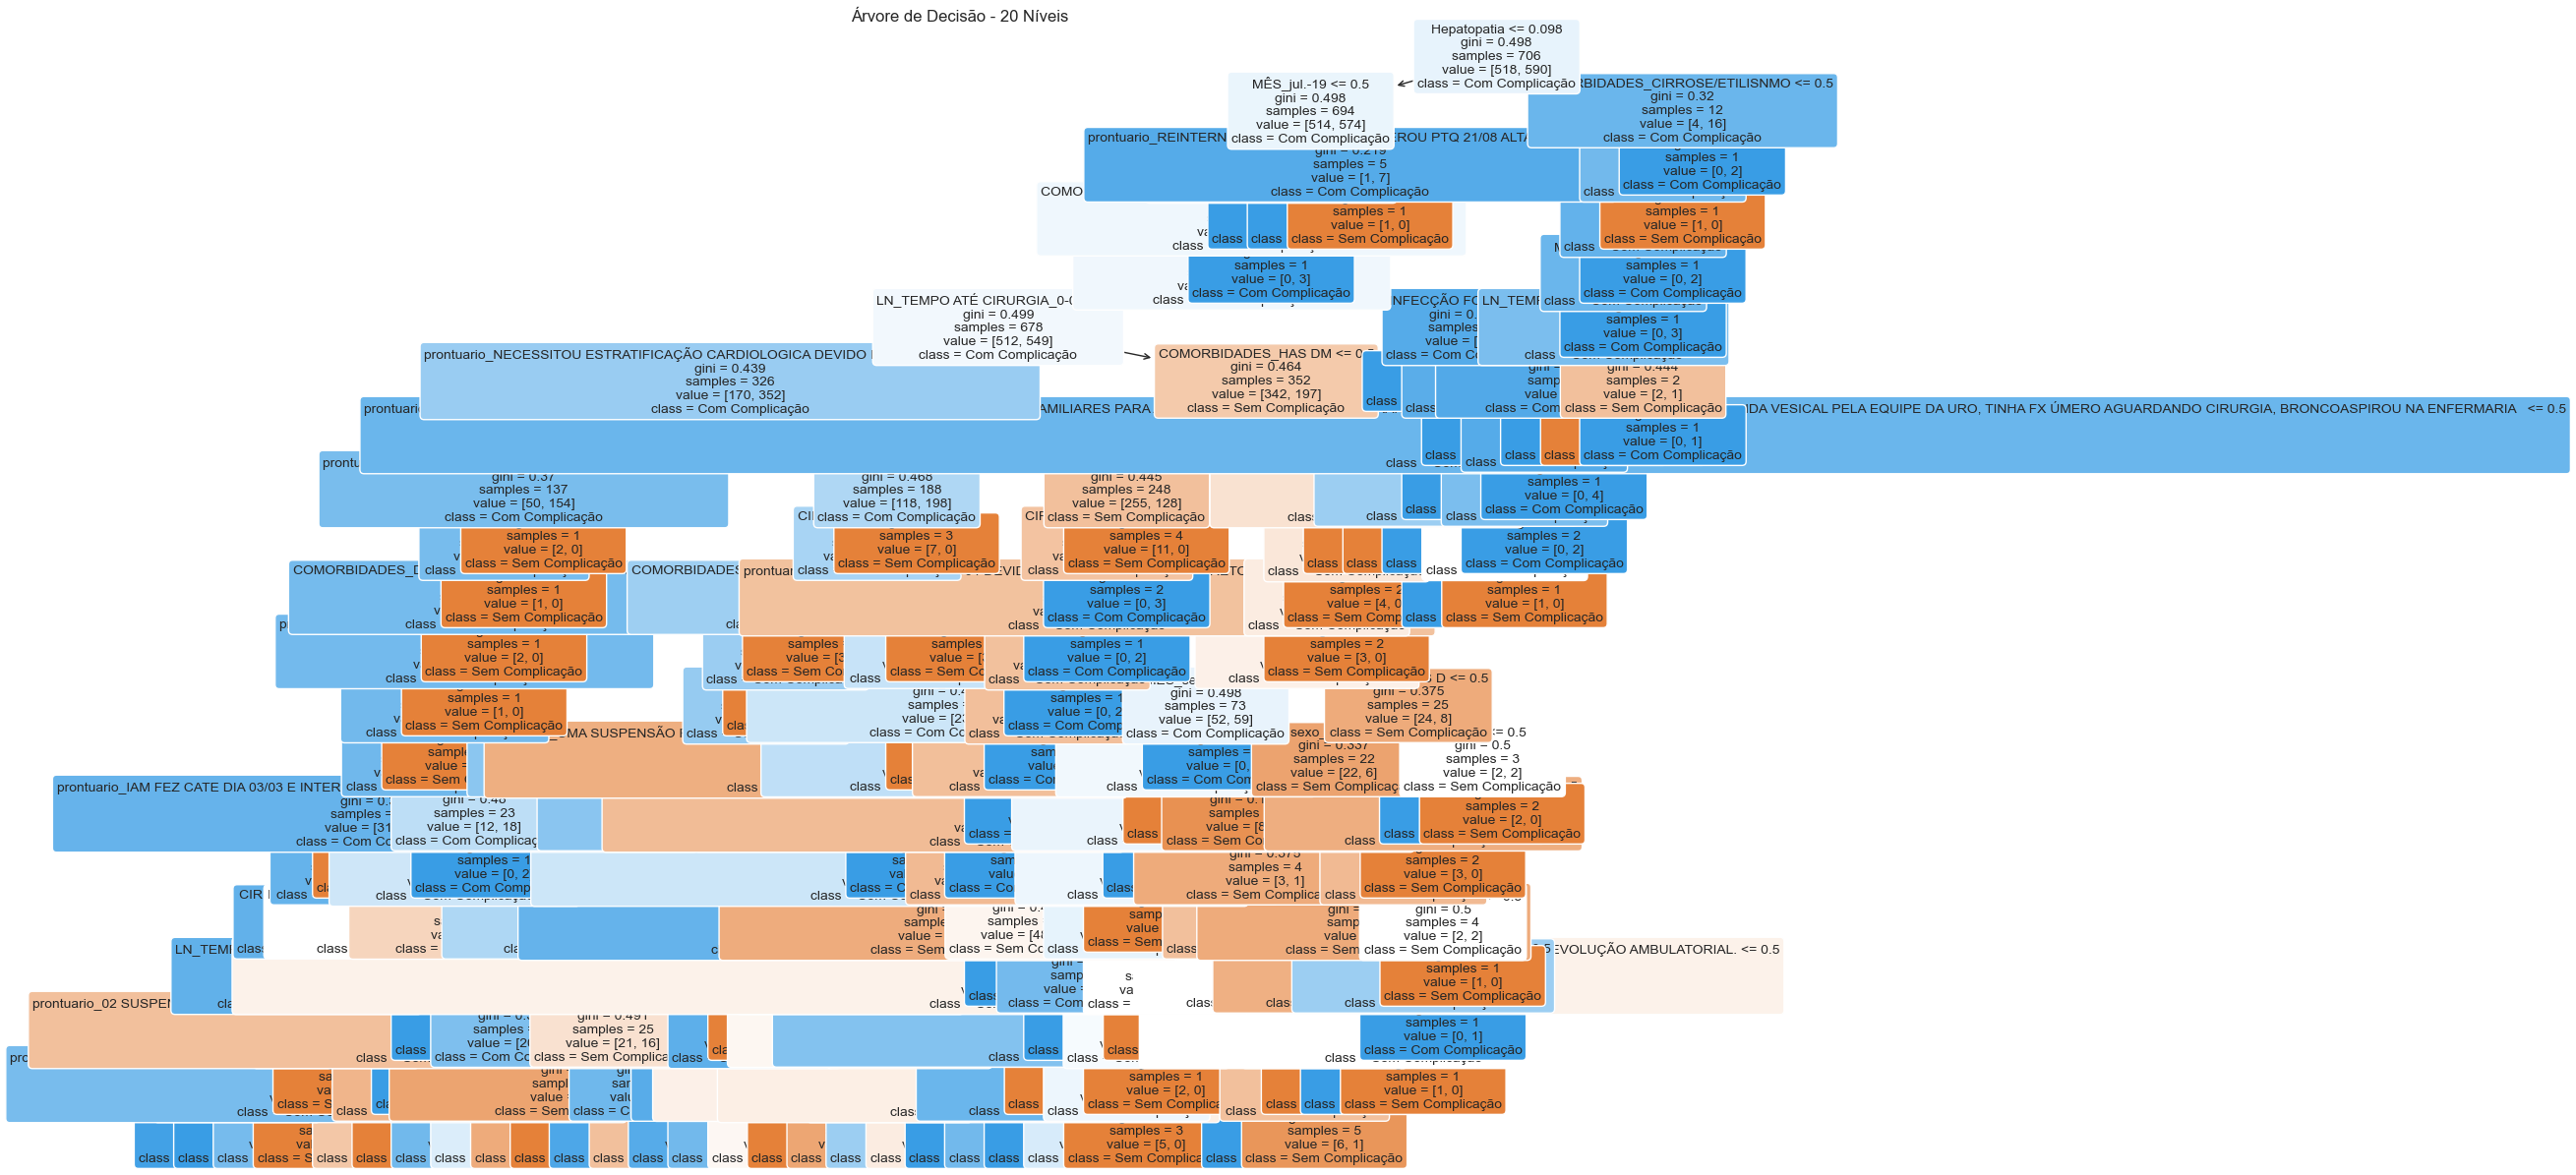

In [28]:
# Selecionando as árvores do modelo treinado
tree_5_levels = best_rf_model.estimators_[0]  # Primeira árvore (ajustada para 5 níveis)
tree_20_levels = best_rf_model.estimators_[1]  # Segunda árvore (ajustada para 20 níveis)

# Visualização da árvore com 5 níveis
plt.figure(figsize=(20, 10))
plot_tree(
    tree_5_levels,
    feature_names=list(X.columns),  # Convertendo os nomes das colunas para lista
    class_names=['Sem Complicação', 'Com Complicação'],  # Classes do modelo
    filled=True,  # Preencher com cores
    rounded=True,  # Nós arredondados
    fontsize=10,  # Tamanho da fonte
    max_depth=5  # Limitar a visualização para 5 níveis
)
plt.title("Árvore de Decisão - 5 Níveis")
plt.show()

# Visualização da árvore com 20 níveis
plt.figure(figsize=(20, 15))
plot_tree(
    tree_20_levels,
    feature_names=list(X.columns),  # Convertendo os nomes das colunas para lista
    class_names=['Sem Complicação', 'Com Complicação'],  # Classes do modelo
    filled=True,  # Preencher com cores
    rounded=True,  # Nós arredondados
    fontsize=10,  # Tamanho da fonte
    max_depth=20  # Limitar a visualização para 20 níveis
)
plt.title("Árvore de Decisão - 20 Níveis")
plt.show()


---


In [3]:
data.to_csv('variaveis_obito.csv')

# Análise Comparativa: Modelo para Prever Complicações vs. Modelo para Prever Óbitos

---

## Semelhanças Entre os Modelos
1. **Estrutura e Metodologia**:
   - Ambos os modelos utilizam **Random Forest**, capturando relações não lineares e interações complexas entre variáveis.
   - Técnicas consistentes de pré-processamento: criação de faixas etárias, variáveis binárias para infecção, tipos de cirurgia e faixas de tempo.

2. **Conjunto de Variáveis**:
   - Ambos utilizam variáveis demográficas (ex.: idade), clínicas (ex.: infecção, complicações) e temporais (ex.: tempo até cirurgia).
   - A variável **COMPLICAÇÃO**, preditora no modelo de óbito, desempenha um papel importante nos dois casos.

3. **Técnicas de Validação**:
   - Ambos utilizam validação cruzada (5-fold) e otimização de hiperparâmetros com GridSearchCV.
   - SMOTE foi aplicado em ambos para lidar com o desbalanceamento das classes.

---

## Diferenças Entre os Modelos

| Aspecto                | Modelo de Complicação                         | Modelo de Óbito                              |
|------------------------|-----------------------------------------------|---------------------------------------------|
| **Variável Alvo**      | **COMPLICAÇÃO**: Presença de complicações.    | **ÓBITO**: Presença de óbito.               |
| **Foco Clínico**       | Identificar pacientes com maior risco de eventos adversos não fatais (ex.: infecção, complicação cirúrgica). | Identificar risco de mortalidade hospitalar. |
| **Importância das Variáveis** | **Infecção, faixas etárias, atrasos no atendimento.** | **Complicação, infecção, tempo até cirurgia, idade avançada.** |
| **Métrica AUC-ROC**    | **0.87**: Boa separabilidade das classes.     | **0.91**: Excelente separabilidade das classes. |
| **Intervenções Esperadas** | Intervenções para evitar complicações clínicas e melhorar o atendimento. | Priorização de pacientes de alto risco para intervenções imediatas. |

---

## Performance Comparativa

### **Modelo de Complicação**
- **AUC-ROC**: 0.87
- **Precisão/Recall da Classe Minoritária (1)**:
  - **Precisão**: 74% → A maioria dos casos previstos como complicação eram verdadeiros.
  - **Recall**: 76% → Identificou 76% de todas as complicações reais.
- **Desempenho Geral**:
  - O modelo equilibra bem precisão e recall.
  - Reduz falsos negativos (complicações reais não detectadas).

### **Modelo de Óbito**
- **AUC-ROC**: 0.91
- **Precisão/Recall da Classe Minoritária (1)**:
  - **Precisão**: 80% → A maioria dos óbitos previstos eram verdadeiros.
  - **Recall**: 78% → Identificou 78% de todos os óbitos reais.
- **Desempenho Geral**:
  - Melhor capacidade de separação entre classes (AUC maior).
  - Leve vantagem em recall e precisão, priorizando mortalidade.

---

## Análise Descritiva das Variáveis

### **Variáveis Comuns**
1. **Infecção**:
   - Forte preditor em ambos os modelos.
   - Indica a gravidade do quadro clínico, com associação direta a complicações e mortalidade.

2. **Idade (faixas etárias)**:
   - Idade avançada (>56 anos) aumenta o risco em ambos.
   - Em complicações, reflete maior fragilidade física.
   - Em óbitos, a idade interage com comorbidades e recuperação mais lenta.

3. **Atrasos no Atendimento (faixas temporais)**:
   - Atrasos são relevantes nos dois modelos.
   - Em complicações, podem estar associados a infecções e falhas no manejo inicial.
   - Em óbitos, atrasos refletem condições emergenciais não tratadas adequadamente.

### **Diferenças**
1. **Complicação**:
   - No modelo de óbito, a variável **COMPLICAÇÃO** é preditiva, indicando que eventos adversos não fatais aumentam significativamente o risco de mortalidade.
   - No modelo de complicação, é a variável alvo.

2. **Eletiva vs. Emergência**:
   - Cirurgias de emergência apresentam maior peso no modelo de óbito.
   - Cirurgias eletivas são menos preditivas para mortalidade, mas ainda impactam o risco de complicação.

---

## Comparação com o Índice de Charlson

### **Modelo de Complicação vs. Charlson**
- **Charlson**:
  - Simples e útil para estimar complicações relacionadas a comorbidades específicas.
  - Porém, ignora fatores temporais e clínicos contextuais (ex.: infecção, atrasos, tipo de cirurgia).
- **Modelo de Complicação**:
  - Supera Charlson ao considerar múltiplos fatores simultaneamente.
  - Recomendado para cenários em que intervenções preventivas podem reduzir complicações (ex.: melhorar tempos hospitalares).

### **Modelo de Óbito vs. Charlson**
- **Charlson**:
  - Bem validado para estimar mortalidade.
  - Desempenho comparável ao modelo de óbito para identificar pacientes com comorbidades graves.
- **Modelo de Óbito**:
  - Considera variáveis contextuais (ex.: complicações, tempos hospitalares), o que melhora a precisão e recall.
  - É superior para prever mortalidade hospitalar em cenários específicos, especialmente onde o tempo até cirurgia ou eventos adversos desempenham papel crítico.

---

## Qual é Melhor?

### **Para Complicações**
- O **modelo de complicação** é claramente superior ao Charlson em prever eventos adversos não fatais.
- Ele permite intervenções preventivas mais eficazes, identificando fatores como infecção e atrasos no atendimento.

### **Para Óbitos**
- O **modelo de óbito** supera Charlson ao incorporar variáveis específicas do ambiente hospitalar.
- É ideal para priorizar pacientes de alto risco em tempo real, enquanto Charlson é mais geral e menos adaptável.

---

## Conclusão Final
1. **Melhor Modelo Geral**:
   - O modelo de **óbito** apresentou melhor desempenho geral (AUC-ROC = 0.91).
   - Sua capacidade de prever mortalidade é mais precisa, o que é crucial em cenários críticos.
2. **Usabilidade**:
   - O modelo de complicação é mais útil para monitoramento e melhorias no atendimento, enquanto o modelo de óbito é mais eficaz em priorizar pacientes.
3. **Impacto na Prática**:
   - Ambos os modelos são superiores ao Charlson em cenários específicos, especialmente quando dados clínicos e temporais estão disponíveis.
4. **Recomendações**:
   - Usar o modelo de óbito para triagem em UTIs e casos emergenciais.
   - Usar o modelo de complicação para implementar protocolos preventivos e melhorar o fluxo hospitalar.

